In [19]:
import pandas as pd

df = pd.read_parquet('../data/principal_components_with_labels.parquet')
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,target
0,-2.919931,2.624154,0.019189,-1.745901,0.048781,-0.584533,-0.066183,-0.361189,-0.154727,0.148172,...,-0.056332,-0.064585,0.045895,0.152312,0.281226,-0.010112,0.068105,-0.070667,0.167720,happy
1,-2.425666,1.943809,-0.162745,-0.835240,0.363333,-0.313617,0.029812,-0.323244,-0.080105,0.165745,...,-0.188452,0.043666,-0.017317,0.046475,0.156812,-0.033735,0.133694,-0.067045,0.096506,happy
2,-2.349361,2.070186,-0.114546,-0.894598,0.222630,-0.289489,0.055417,-0.403261,-0.043620,0.193918,...,-0.208188,0.076526,0.010672,0.041231,0.148540,-0.004347,0.134377,-0.059920,0.083128,happy
3,-2.319039,2.211985,-0.107307,-1.027317,0.142543,-0.316502,0.069175,-0.457194,-0.072606,0.186789,...,-0.209320,0.102759,0.033662,0.049343,0.149298,-0.001055,0.103226,-0.079370,0.087087,happy
4,-2.796665,2.635584,0.039614,-0.940008,0.081617,-0.168472,0.180836,-0.499248,-0.077225,0.123918,...,-0.271494,0.069542,0.028476,0.186310,0.103916,-0.020695,0.113482,-0.058791,0.093259,happy


In [20]:
import numpy as np

feature_cols = [col for col in df.columns if col.startswith('PC')]

def create_sliding_windows(data, label_col, window_size, step_size):
    sequences = []
    labels = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        sequences.append(window[feature_cols].values)
        label = window[label_col].mode()[0]
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 30
step_size = 5
X, y = create_sliding_windows(df, label_col='target', window_size=window_size, step_size=step_size)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(73631, 30, 20) (73631,) (18408, 30, 20) (18408,) (10227, 30, 20) (10227,)


In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [23]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [24]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def fit_and_plot(model):
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    labels = ['angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

## Base RNN with LSTM

In [26]:
model_lstm_1 = Sequential([
    Input(shape=(window_size, len(feature_cols))),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_lstm_1.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           76288     
                                                                 
 batch_normalization_4 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 64)               

Epoch 1/100
4602/4602 [==============================] - 80s 17ms/step - loss: 1.6729 - accuracy: 0.3164 - val_loss: 1.5326 - val_accuracy: 0.3946 - lr: 5.0000e-04
Epoch 2/100
4602/4602 [==============================] - 75s 16ms/step - loss: 1.5482 - accuracy: 0.3875 - val_loss: 1.4499 - val_accuracy: 0.4364 - lr: 5.0000e-04
Epoch 3/100
4602/4602 [==============================] - 76s 17ms/step - loss: 1.4693 - accuracy: 0.4306 - val_loss: 1.3847 - val_accuracy: 0.4770 - lr: 5.0000e-04
Epoch 4/100
4602/4602 [==============================] - 78s 17ms/step - loss: 1.3920 - accuracy: 0.4708 - val_loss: 1.2944 - val_accuracy: 0.5174 - lr: 5.0000e-04
Epoch 5/100
4602/4602 [==============================] - 77s 17ms/step - loss: 1.3074 - accuracy: 0.5114 - val_loss: 1.1975 - val_accuracy: 0.5554 - lr: 5.0000e-04
Epoch 6/100
4602/4602 [==============================] - 77s 17ms/step - loss: 1.2216 - accuracy: 0.5508 - val_loss: 1.1128 - val_accuracy: 0.5956 - lr: 5.0000e-04
Epoch 7/100
4602

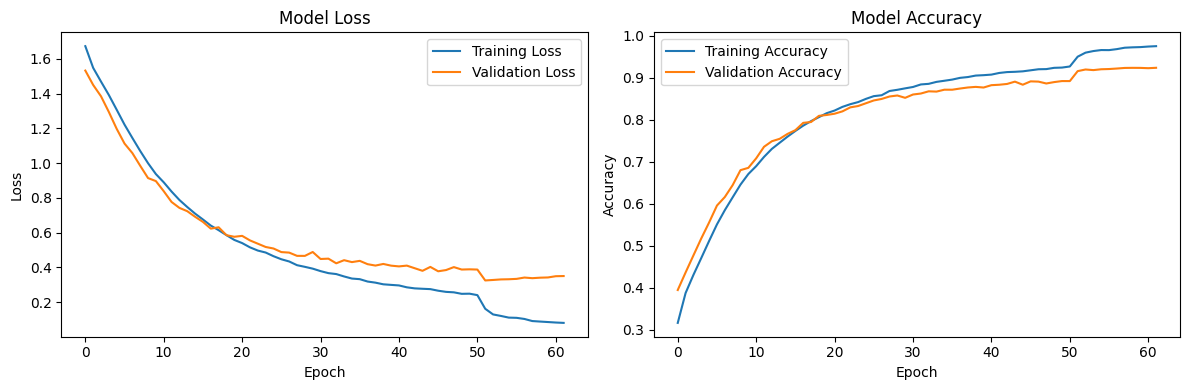

320/320 [==============================] - 3s 8ms/step - loss: 0.3167 - accuracy: 0.9184
Test Loss: 0.3167, Test Accuracy: 0.9184
320/320 [==============================] - 3s 7ms/step


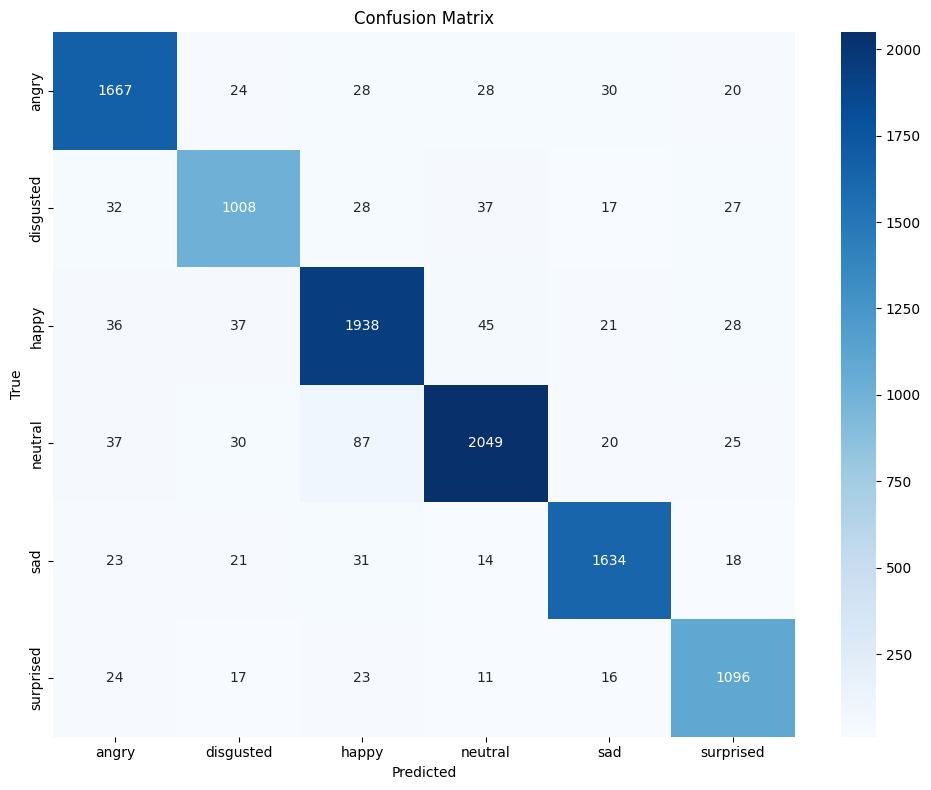

In [27]:
fit_and_plot(model_lstm_1)

In [28]:
model_lstm_1.save('../models/facial_emotion_classifier.h5')

In [29]:
model_lstm_2xlr = Sequential([
    Input(shape=(window_size, len(feature_cols))),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_lstm_2xlr.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm_2xlr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 128)           76288     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)               

Epoch 1/100
4602/4602 [==============================] - 100s 21ms/step - loss: 1.6869 - accuracy: 0.3050 - val_loss: 1.6051 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 2/100
4602/4602 [==============================] - 106s 23ms/step - loss: 1.5894 - accuracy: 0.3654 - val_loss: 1.5195 - val_accuracy: 0.4069 - lr: 0.0010
Epoch 3/100
4602/4602 [==============================] - 91s 20ms/step - loss: 1.5344 - accuracy: 0.3946 - val_loss: 1.4613 - val_accuracy: 0.4345 - lr: 0.0010
Epoch 4/100
4602/4602 [==============================] - 77s 17ms/step - loss: 1.4682 - accuracy: 0.4272 - val_loss: 1.3777 - val_accuracy: 0.4678 - lr: 0.0010
Epoch 5/100
4602/4602 [==============================] - 77s 17ms/step - loss: 1.4048 - accuracy: 0.4615 - val_loss: 1.3083 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 6/100
4602/4602 [==============================] - 77s 17ms/step - loss: 1.3387 - accuracy: 0.4949 - val_loss: 1.2476 - val_accuracy: 0.5302 - lr: 0.0010
Epoch 7/100
4602/4602 [===============

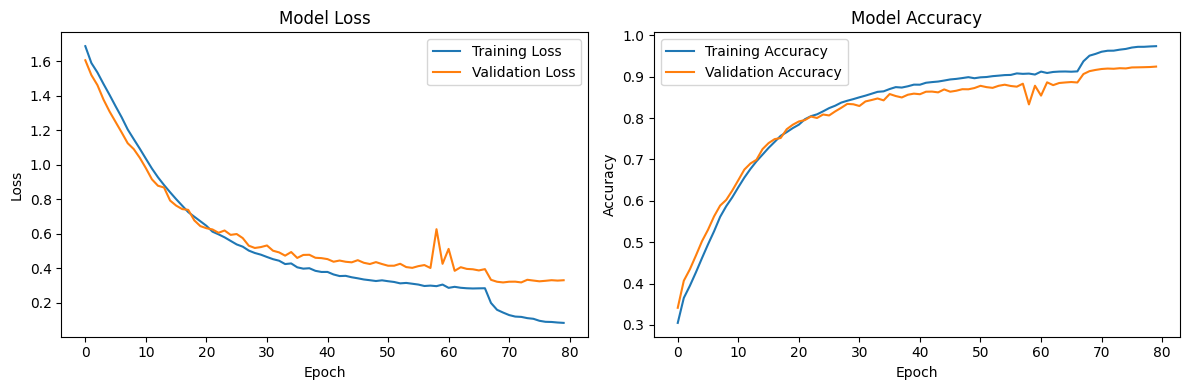

320/320 [==============================] - 3s 8ms/step - loss: 0.3542 - accuracy: 0.9079
Test Loss: 0.3542, Test Accuracy: 0.9079
320/320 [==============================] - 3s 8ms/step


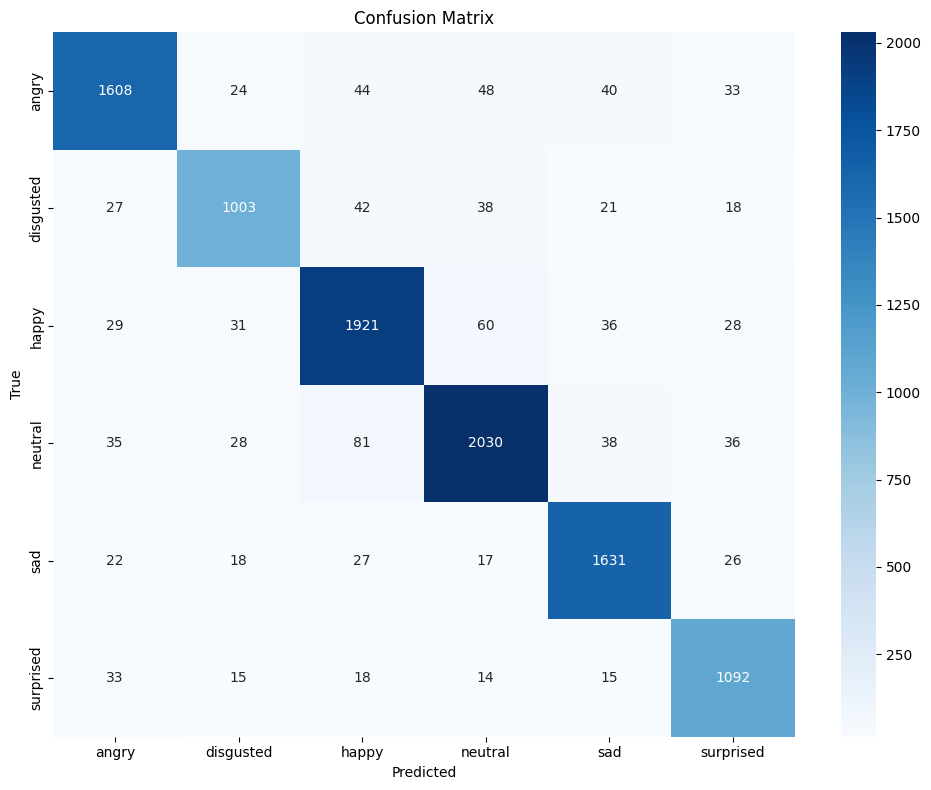

In [30]:
fit_and_plot(model_lstm_2xlr)

In [31]:
from keras.optimizers import Adadelta

model_lstm_adadelta = Sequential([
    Input(shape=(window_size, len(feature_cols))),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_lstm_adadelta.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm_adadelta.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 128)           76288     
                                                                 
 batch_normalization_8 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 64)               

In [32]:
fit_and_plot(model_lstm_adadelta)

Epoch 1/100
4602/4602 [==============================] - 88s 19ms/step - loss: 2.0369 - accuracy: 0.1799 - val_loss: 1.8872 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 2/100
4602/4602 [==============================] - 80s 17ms/step - loss: 1.9637 - accuracy: 0.1892 - val_loss: 1.8219 - val_accuracy: 0.2231 - lr: 0.0010
Epoch 3/100
4602/4602 [==============================] - 82s 18ms/step - loss: 1.9203 - accuracy: 0.2010 - val_loss: 1.7849 - val_accuracy: 0.2404 - lr: 0.0010
Epoch 4/100
3278/4602 [====================>.........] - ETA: 22s - loss: 1.8951 - accuracy: 0.2087